In [1]:
# From http://stackoverflow.com/questions/493174/is-there-a-way-to-convert-number-words-to-integers
def text2int(textnum, numwords={}):
    if not numwords:
      units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen",
      ]

      tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

      scales = ["hundred", "thousand", "million", "billion", "trillion"]

      numwords["and"] = (1, 0)
      for idx, word in enumerate(units):    numwords[word] = (1, idx)
      for idx, word in enumerate(tens):     numwords[word] = (1, idx * 10)
      for idx, word in enumerate(scales):   numwords[word] = (10 ** (idx * 3 or 2), 0)

    current = result = 0
    for word in textnum.split():
        if word not in numwords:
          raise Exception("Illegal word: " + word)

        scale, increment = numwords[word]
        current = current * scale + increment
        if scale > 100:
            result += current
            current = 0

    return result + current

In [2]:
def ordinal_text2int(textnum):
    ordinal_nums = {'first': '1st', 'second': '2nd', 'third': '3rd', 'fourth': '4th', 
                    'fifth': '5th', 'sixth': '6th', 'seventh': '7th', 'eighth': '8th', 
                    'ninth': '9th', 'tenth': '10th'}
    return ordinal_nums[textnum]

In [3]:
def is_article_quote(text):
    if (text[0] == "'" and "http" in text) or "' http" in text or "'\nhttp" in text:
        return True
    return False

def is_copy_paste(text):
    if '"@' in text:
        return True
    
    in_quotes = False
    seen_quotes = 0
    saw_at = False
    for c in text:
        if c == '"':
            in_quotes = not in_quotes
            if saw_at:
                seen_quotes += 1
        if c == '@' and not in_quotes:
            saw_at = True

    return saw_at and seen_quotes % 2 == 1

## Does Trump Have the "Best Words"?

Trump said *"I Know Words, I Have The Best Words."* So I'm comparing his Tweeter vocabulary with Clinton's to see if his tweets reflect this statement.

There are many steps done to clean the data. They are enumerated below, and then described in more detail in the cells preceeding the associated code.

1. Flag article quotes.
2. Flag copy-pasted tweets (common among Trump's Android tweets).
3. Remove tweets flagged as quotes and copy-pasted tweets from the analysis.
4. Tokenize tweets. 
5. Tag words using the Stanford Named Entity Recognition (NER) Tagger. Exclude person names, organizations, locations, quantities, etc. 
6. Exclude stopwords, words with less than 3 characters, words that were not separated from formatted quotation marks, words that include a forward slash, hashtags, user mentions, punctuation marks, etc.
7. Calculate the vocabulary size and the average word frequency by stemming/lemmatizing each of the remaining words.

In [4]:
import os
import re
import sys
import itertools
from copy import deepcopy
from datetime import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import StanfordNERTagger
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [5]:
os.environ['STANFORD_MODELS'] = "/Users/gogrean/code/stanford-ner-2014-06-16/classifiers"
os.environ['CLASSPATH'] = "/Users/gogrean/code/stanford-ner-2014-06-16"
st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')

wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

In [6]:
root_dir = "/Users/gogrean/Documents/kaggle/off_kaggle_ds/trump_tweets/data/"
df_trump = pd.read_csv(root_dir + "trumps_tweets.csv")

root_dir = "/Users/gogrean/Documents/kaggle/off_kaggle_ds/hc_tweets/data/"
df_clinton = pd.read_csv(root_dir + "hcs_tweets.csv")

I flag article quotes and copy-pasted tweets, and exclude them from the analysis. Trump, when tweeting from Android, often retweets by copy-pasting another user's tweet. These tweets are excluded from the analysis in their entirety, even if the retweet is followed by some of Trump's own words. The same thinking is applied to tweets that contain article quotes&mdash;even if part of the tweet contains one of the candidates' own words, the full tweet is excluded.

In [7]:
for i, text in enumerate(df_trump.text):
    df_trump.at[i, 'copy_paste'] = is_copy_paste(text)
    df_trump.at[i, 'article_quote'] = is_article_quote(text)

for i, text in enumerate(df_clinton.text):
    df_clinton.at[i, 'copy_paste'] = is_copy_paste(text)
    df_clinton.at[i, 'article_quote'] = is_article_quote(text)

filtered_tweets_trump = df_trump[(df_trump.copy_paste == False) & (df_trump.article_quote == False) &
                                 (df_trump.is_retweet == False)]
filtered_tweets_clinton = df_clinton[(df_clinton.copy_paste == False) & (df_clinton.article_quote == False) & 
                                     (df_clinton.is_retweet == False)]

Next I tokenize the tweets. Some of Trump's Android tweets are not fully tokenized because a blank space is missing after the punctuation mark separating two sentences. `nltk` can't seem to deal with the sloppiness, so I'm fixing the tweets by hand. Looping over the tweets, I then run `separate_sentences` on every tweet, tokenize the text, tag the words using the Stanford NER Tagger, and remove hashtags, user mentions, stopwords, 1-2 character words, punctuation marks, person names, locations, etc. I also exclude words that have forward slashes and formatted quotation marks in them.

In [8]:
punctuation_marks = ["!", ".", "?", ";", ":", "?!", ")", "(", "'", 
                     '"', ",", "-", "...", "…", "``", "`", "’", "“", 
                     '#', "&", "@", "—", "–", "”", "‘"]

from nltk.corpus import wordnet

def pos_translator(orig_pos_tag):
    if orig_pos_tag.startswith('N'):
        return 'n'
    elif orig_pos_tag.startswith('V'):
        return 'v'
    elif orig_pos_tag.startswith('J'):
        return 'a'
    elif orig_pos_tag.startswith('R'):
        return 'r'
    return 'n'

def make_corpus(df):
    n_chars, n_tokens = 0, 0
    tokenized_corpus = []
    flagged_indices = []
    url_regex = re.compile(r'https?:\/\/[a-zA-z0-9\/#%\.]+')
    for tweet, hashtags, mentions in zip(df.text, df.hashtags, df.user_mentions):
        n_chars += len(tweet)
        hashtag_list, mention_list = [], []
        if hashtags is not np.nan:
            hashtag_list = [h for h in hashtags.lower().split(", ")]
        if mentions is not np.nan:
            mention_list = [m for m in mentions.lower().split(", ")]
        tweet = re.sub(url_regex, '', tweet)
        tokens = word_tokenize(tweet)
        for dash in ["—", "–", "/"]:
            offset = 0
            split_words = [(i, word) for i, word in enumerate(tokens) if dash in word]
            for i, word in split_words:
                i += offset
                subwords = [subword for subword in word.split(dash) if subword != '']
                tokens[i:i+1] = subwords
                offset += (len(subwords) - 1)

        this_tweet_flagged_indices = [n_tokens + i 
                                      for i, w in enumerate(tokens) 
                                      if w.lower() in hashtag_list or w.lower() in mention_list]
        n_tokens += len(tokens)
        tokenized_corpus.extend(tokens)
        flagged_indices += this_tweet_flagged_indices
    return n_chars, flagged_indices, tokenized_corpus

def remove_numbers(tags):
    tags_with_nums = deepcopy(tags)
    for (w, t) in tags_with_nums:
        try:
            num = text2int(w)
            is_num_card = True
        except:
            is_num_card = False
        try:
            num = ordinal_text2int(w)
            is_num_ord = True
        except:
            is_num_ord = False
        if is_num_card or is_num_ord:
            tags.remove((w, t))
    return tags

def tag_corpus(tokenized_corpus, flagged_indices=[], method='stemming'):
    stopset = stopwords.words('english')
    wordcloud_text = ''
    superlatives = 0
    forbidden = ["http", "//", "amp"] + punctuation_marks
    tags = st.tag(tokenized_corpus)
    modified_corpus = False
    for i, w in enumerate(tags):
        if w[0].isupper() and w[1] == 'O':
            tokenized_corpus[i] = w[0].title()
            modified_corpus = True
    if modified_corpus:
        tags = st.tag(tokenized_corpus)
    pos_tags = nltk.pos_tag(tokenized_corpus)
    for index in reversed(flagged_indices):
        del tags[index]
        del pos_tags[index]
    tags = remove_numbers(tags)
    pos_tags = remove_numbers(pos_tags)
    if method is 'lemmatization':
        words_in_corpus = [wordnet_lemmatizer.lemmatize(w[0].lower(), pos=pos_translator(p[1])) 
                           for w, p in zip(tags, pos_tags) 
                           if w[1] == 'O' and w[0].lower() not in stopset and
                           len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
                           not any(f in w[0] for f in forbidden)]
        wordcloud_text = " ".join(words_in_corpus)
    else:
        words_in_corpus = [porter_stemmer.stem(w[0].lower()) 
                           for w in tags
                           if w[1] == 'O' and w[0].lower() not in stopset and
                           len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
                           not any(f in w[0] for f in forbidden)]
        wordcloud_text = " ".join(words_in_corpus)
    superlatives = [w[0].lower() for w, p in zip(tags, pos_tags)
                    if w[1] == 'O' and w[0].lower() not in stopset and
                    len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
                    not any(f in w[0] for f in forbidden) and
                    ((p[1] == 'JJS') or (p[1]) == 'RBS') and 
                    'honest' not in w[0].lower() and 
                    'invest' not in w[0].lower()]
    n_words = len(words_in_corpus)
    unique_words = set(words_in_corpus)
    return n_words, superlatives, unique_words, wordcloud_text

In [9]:
n_chars_trump, flagged_indices_trump, corpus_trump = make_corpus(filtered_tweets_trump)
n_words_trump, _, voc_trump, _ = tag_corpus(corpus_trump, flagged_indices_trump)

n_chars_clinton, flagged_indices_clinton, corpus_clinton = make_corpus(filtered_tweets_clinton)
n_words_clinton, _, voc_clinton, _ = tag_corpus(corpus_clinton, flagged_indices_clinton)

In [10]:
word_freq_clinton = n_words_clinton / len(voc_clinton)
print("On average, Clinton repeat a word approximately %.1f times." % word_freq_clinton)

word_freq_trump = n_words_trump / len(voc_trump)
print("On average, Trump repeat a word approximately %.1f times." % word_freq_trump)

On average, Clinton repeat a word approximately 6.6 times.
On average, Trump repeat a word approximately 7.4 times.


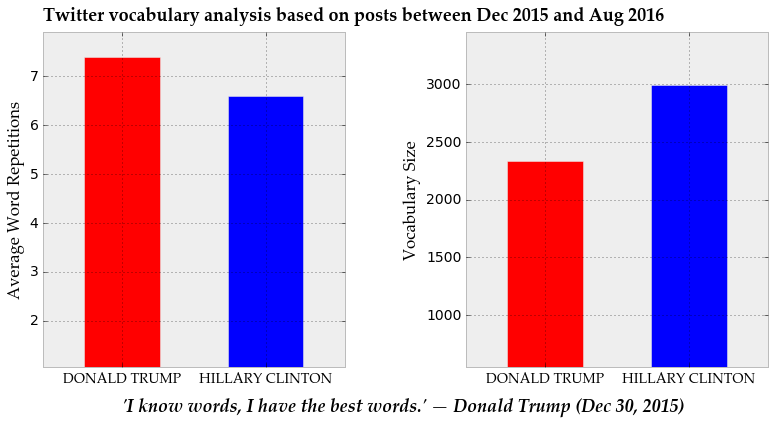

In [12]:
plt.rcParams.update({'font.size': 14})
pfont = {'fontname': 'Palatino Linotype'}

plt.style.use('bmh')
fig, ax = plt.subplots(1, 2, figsize=(13,6))

bar_pos = [0.31, 0.69]
bar_width = 0.2

ax[0].bar(bar_pos, [word_freq_trump, word_freq_clinton], width=0.2, color=['red', 'blue'])
ax[0].set_xticks([pos + bar_width/2 for pos in bar_pos])
ax[0].set_xticklabels(["DONALD TRUMP", "HILLARY CLINTON"], **pfont)
ax[0].set_title("Twitter vocabulary analysis based on posts between Dec 2015 and Aug 2016", 
                loc='left', y=1.02, fontsize=18, weight='bold', **pfont)
ax[0].set_ylabel('Average Word Repetitions', **pfont)
ax[0].set_ylim([1.05,7.9])
ax[0].set_xlim([0.2,1.0])

ax[1].bar(bar_pos, [len(voc_trump), len(voc_clinton)], width=0.2, color=['red', 'blue'])
ax[1].set_xticks([pos + bar_width/2 for pos in bar_pos])
ax[1].set_xticklabels(["DONALD TRUMP", "HILLARY CLINTON"], **pfont)
ax[1].set_ylabel('Vocabulary Size', **pfont)
ax[1].set_ylim([550,3450])
ax[1].set_xlim([0.2,1.0])
fig.subplots_adjust(wspace=0.4)

fig.text(.21, .02, "'I know words, I have the best words.' — Donald Trump (Dec 30, 2015)", 
         style='oblique', weight='bold', fontsize=18, **pfont)

rootdir = "/Users/gogrean/Documents/kaggle/off_kaggle_ds/combined_analysis/images"
fig.savefig(rootdir + '/trump_vs_clinton_vocabulary.pdf')

(-0.5, 355.5, 353.5, -0.5)

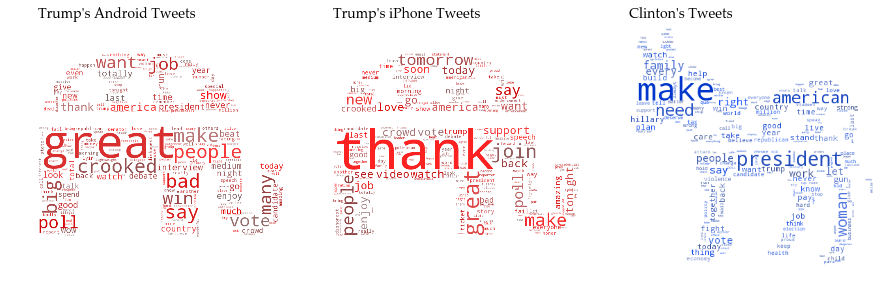

In [13]:
import random
from PIL import Image
from wordcloud import WordCloud

def rep_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(%d, %d%%, %d%%)" % (0, random.randint(10, 100), random.randint(40, 60))

def dem_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(%d, %d%%, %d%%)" % (224, random.randint(40, 100), random.randint(40, 60))

android = '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>'
iphone = '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'
filtered_tweets_trump_android = df_trump[(df_trump.copy_paste == False) & (df_trump.article_quote == False) &
                                         (df_trump.is_retweet == False) & 
                                         (df_trump.source == android)]
filtered_tweets_trump_iphone = df_trump[(df_trump.copy_paste == False) & (df_trump.article_quote == False) &
                                         (df_trump.is_retweet == False) & 
                                         (df_trump.source == iphone)]

_, flagged_indices_trump_android, corpus_trump_android = make_corpus(filtered_tweets_trump_android)
_, sup_trump_android, voc_trump_android, wordcloud_trump_android = tag_corpus(corpus_trump_android, 
                                                                              flagged_indices_trump_android, 
                                                                              method='lemmatization')

_, flagged_indices_trump_iphone, corpus_trump_iphone = make_corpus(filtered_tweets_trump_iphone)
_, sup_trump_iphone, voc_trump_iphone, wordcloud_trump_iphone = tag_corpus(corpus_trump_iphone, 
                                                                           flagged_indices_trump_iphone, 
                                                                           method='lemmatization')

_, flagged_indices_clinton, corpus_clinton_lem = make_corpus(filtered_tweets_clinton)
_, sup_clinton, voc_clinton, wordcloud_clinton = tag_corpus(corpus_clinton_lem, flagged_indices_clinton, 
                                                            method='lemmatization')

fig, ax = plt.subplots(1, 3, figsize=(15,6))

# masks taken from here:
# https://image.freepik.com/free-icon/elephant-republican-symbol_318-64492.jpg
# https://www.carstickers.com/prodimages/12960-democrat-donkey-sticker.png
republican_mask = np.array(Image.open(rootdir+'/republican-symbol.jpg'))
democrat_mask = np.array(Image.open(rootdir+'/democrat-symbol.jpg'))

wc_trump_android = WordCloud(background_color="white", 
                             max_words=200, 
                             mask=republican_mask, width=5000, height=5000)
wc_trump_android.generate(wordcloud_trump_android)
wc_trump_android.recolor(random_state=5, color_func=rep_color_func)

wc_trump_iphone = WordCloud(background_color="white", 
                            max_words=200, 
                            mask=republican_mask, width=5000, height=5000)
wc_trump_iphone.generate(wordcloud_trump_iphone)
wc_trump_iphone.recolor(random_state=5, color_func=rep_color_func)

wc_clinton = WordCloud(background_color="white", 
                       max_words=200, 
                       mask=democrat_mask, width=5000, height=5000)
wc_clinton.generate(wordcloud_clinton)
wc_clinton.recolor(random_state=5, color_func=dem_color_func)

ax[0].set_title("Trump's Android Tweets", loc='left', fontsize=14, **pfont)
ax[0].imshow(wc_trump_android)
ax[0].axis('off')

ax[1].set_title("Trump's iPhone Tweets", loc='left', fontsize=14, **pfont)
ax[1].imshow(wc_trump_iphone)
ax[1].axis('off')

ax[2].set_title("Clinton's Tweets", loc='left', fontsize=14, **pfont)
ax[2].imshow(wc_clinton)
ax[2].axis('off')

In [14]:
fig.savefig(rootdir + '/wordclouds_twitter.png', dpi=400)

In [167]:
n_superlatives_trump_android = len(sup_trump_android)
n_words_trump_android = len(wordcloud_trump_android.split())
print("%.1f of Trump's Android tweet words are superlatives." 
      % (n_superlatives_trump_android / n_words_trump_android * 100.))
sorted(set(sup_trump_android))

0.4 of Trump's Android tweet words are superlatives.


['best',
 'biggest',
 'dumbest',
 'highest',
 'largest',
 'least',
 'lowest',
 'weakest',
 'worst']

In [168]:
n_superlatives_trump_iphone = len(sup_trump_iphone)
n_words_trump_iphone = len(wordcloud_trump_iphone.split())
print("%.1f of Trump's iPhone tweet words are superlatives." 
      % (n_superlatives_trump_iphone / n_words_trump_iphone * 100.))
sorted(set(sup_trump_iphone))

0.3 of Trump's iPhone tweet words are superlatives.


['best',
 'dumbest',
 'earnest',
 'greatest',
 'highest',
 'largest',
 'latest',
 'least',
 'worst']

In [169]:
sup_trump = sup_trump_iphone + sup_trump_android
n_superlatives_trump = n_superlatives_trump_android + n_superlatives_trump_iphone
n_words_trump = n_words_trump_iphone + n_words_trump_android
print("%.1f of Trump's tweet words are superlatives." 
      % (n_superlatives_trump / n_words_trump * 100.))
sorted(set(sup_trump))

0.4 of Trump's tweet words are superlatives.


['best',
 'biggest',
 'dumbest',
 'earnest',
 'greatest',
 'highest',
 'largest',
 'latest',
 'least',
 'lowest',
 'weakest',
 'worst']

In [1]:
n_superlatives_clinton = len(sup_clinton)
n_words_clinton = len(wordcloud_clinton.split())
print("%.2f\% of Clinton's tweet words are superlatives." 
      % (n_superlatives_clinton / n_words_clinton * 100.))
sorted(set(sup_clinton))

NameError: name 'sup_clinton' is not defined

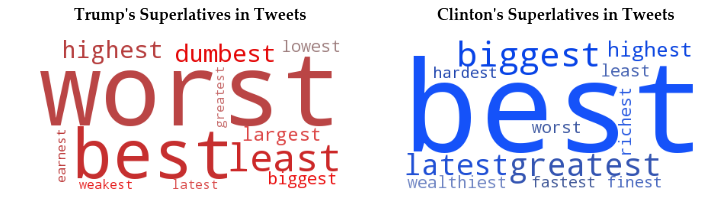

In [171]:
import random
from PIL import Image
from wordcloud import WordCloud

def rep_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(%d, %d%%, %d%%)" % (0, random.randint(10, 100), random.randint(40, 60))

def dem_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(%d, %d%%, %d%%)" % (224, random.randint(40, 100), random.randint(40, 60))

fig, ax = plt.subplots(1, 2, figsize=(12,4))

wc_sup_trump = WordCloud(background_color="white", 
                         max_words=12)
wc_sup_trump.generate(" ".join(sup_trump))
wc_sup_trump.recolor(random_state=10, color_func=rep_color_func)

wc_sup_clinton = WordCloud(background_color="white", 
                           max_words=12)
wc_sup_clinton.generate(" ".join(sup_clinton))
wc_sup_clinton.recolor(random_state=10, color_func=dem_color_func)

ax[0].set_title("Trump's Superlatives in Tweets", 
                fontsize=16, y=1.1, weight='bold', **pfont)
ax[0].imshow(wc_sup_trump)
ax[0].axis('off')

ax[1].set_title("Clinton's Superlatives in Tweets", 
                fontsize=16, y=1.1, weight='bold', **pfont)
ax[1].imshow(wc_sup_clinton)
ax[1].axis('off')
fig.savefig(rootdir + '/wordclouds_twitter_superlatives.png', dpi=400)